# Fun with Variational Autoencoders

This is a starter kernel to use **Labelled Faces in the Wild (LFW) Dataset** in order to maintain knowledge about main Autoencoder principles. PyTorch will be used for modelling.


### **Fork it and give it an upvote.**




![architecture](https://miro.medium.com/max/3636/1*LSYNW5m3TN7xRX61BZhoZA.png)

Useful links:


* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Conditional VAE (Russian)](https://habr.com/ru/post/331664/)
* [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
* [Introducing Variational Autoencoders (in Prose and Code)](https://blog.fastforwardlabs.com/2016/08/12/introducing-variational-autoencoders-in-prose-and.html)
* [How Autoencoders work - Understanding the math and implementation (Notebook)](https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases)
* [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)



# A bit of theory

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

source: https://blog.keras.io/building-autoencoders-in-keras.html


In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cpu


In [2]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

# Explore the data

In [3]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

person                                               path
0     Princess_Maxima  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
1  Ali_Mohammed_Maher  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
2        Elvis_Stojko  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
3        Yves_Brodeur  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
4        Monica_Serra  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
5         Valeri_Bure  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
6         Jim_Edmonds  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
7         Jim_Edmonds  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
8         Gerry_Kelly  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...
9           Tom_Kelly  /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw...

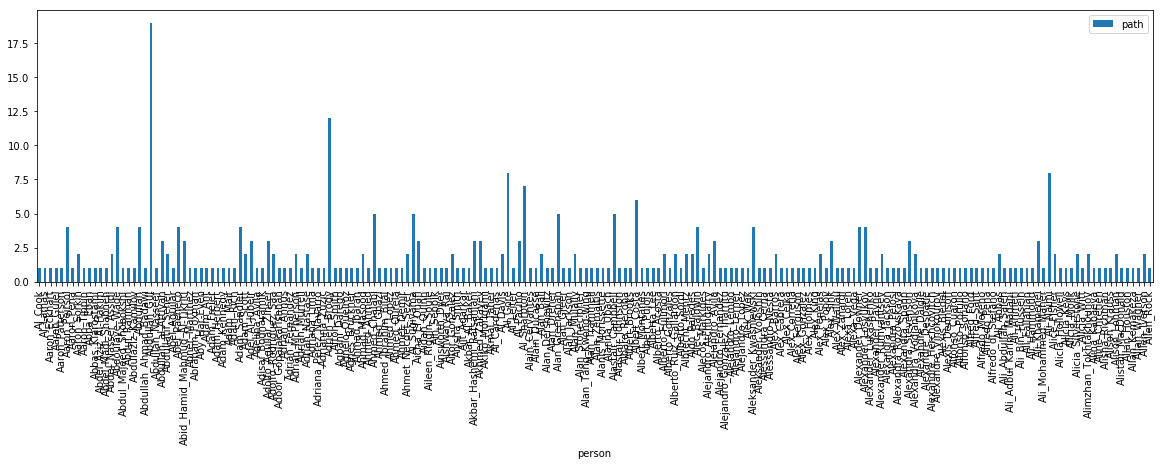

In [4]:
dataset.groupby("person").count()[:200].plot(kind='bar', figsize=(20,5))

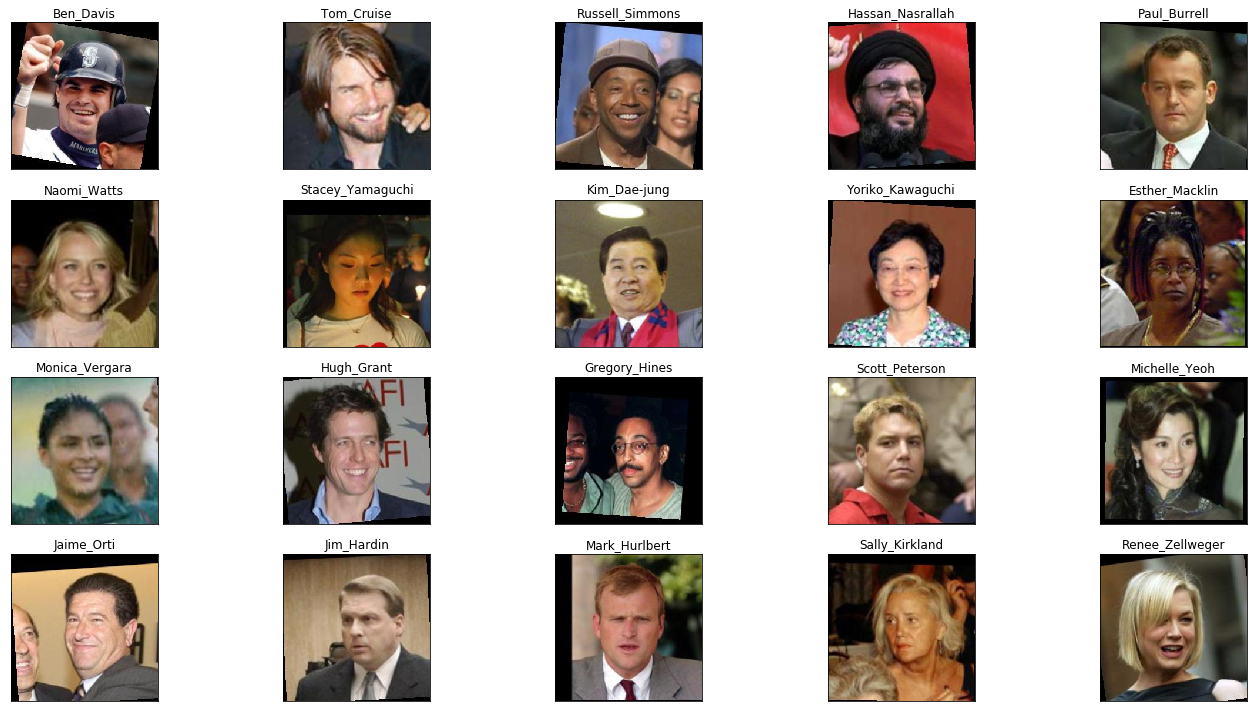

In [5]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Prepare the dataset

In [6]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [7]:
data, attrs = fetch_dataset()

In [8]:
#45,45
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [9]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [10]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

# Building simple autoencoder

In [11]:
dim_z=100

In [12]:
X_train.shape

torch.Size([10514, 45, 45, 3])

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.BatchNorm1d(dim_z),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            #nn.Linear(500,1000),
            #nn.ReLU(),
            nn.Linear(1000,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )
      
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        encoded = self.encode(x) 
        decoded = self.decode(encoded)     

        
        return encoded, decoded

In [14]:
class Autoencoder_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=2),
            #nn.ReLU(),
            #nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5, stride=2)
        )
        
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        x = x.permute(0,3,1,2)
        encoded = self.encoder(x)  
        decoded = self.decode(encoded)     

        
        return encoded, decoded

In [15]:
model_auto = Autoencoder().to(DEVICE)

# Train autoencoder

In [16]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        #print('decoder shape: ', decoder.shape)
        
        if not is_cnn:
            outputs = decoder.view(-1, 45*45*3)
        else:
            outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            if not is_cnn:
                outputs = decoder.view(-1, 45*45*3)
            else:
                outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        if not is_cnn:            
            pic_input = pic.view(-1, 45*45*3)
        else:
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
            
        pic_input = pic_input.to(DEVICE)        
        encoder, decoder = model(pic_input)
        
        if not is_cnn:
            pic_output = decoder.view(-1, 45*45*3).squeeze()
        else:
            pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")        
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=False):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model,train_x,criterion,optimizer,batch_size,is_cnn)
            val_loss = eval_epoch(model,val_x,criterion, is_cnn)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:40<32:55, 40.32s/it]

loss:  0.03150091879459554

Epoch 001 train_loss: 0.0315 val_loss: 0.0176


epoch:   4%|▍         | 2/50 [01:16<31:16, 39.10s/it]

loss:  0.01302191319533326

Epoch 002 train_loss: 0.0130 val_loss: 0.0119


epoch:   6%|▌         | 3/50 [01:52<29:53, 38.16s/it]

loss:  0.011254949418841

Epoch 003 train_loss: 0.0113 val_loss: 0.0107


epoch:   8%|▊         | 4/50 [02:29<28:57, 37.77s/it]

loss:  0.010277011975276112

Epoch 004 train_loss: 0.0103 val_loss: 0.0101


epoch:  10%|█         | 5/50 [03:07<28:17, 37.73s/it]

loss:  0.009579252349437756

Epoch 005 train_loss: 0.0096 val_loss: 0.0093


epoch:  12%|█▏        | 6/50 [03:45<27:50, 37.96s/it]

loss:  0.008879386254054626

Epoch 006 train_loss: 0.0089 val_loss: 0.0090


epoch:  14%|█▍        | 7/50 [04:25<27:32, 38.44s/it]

loss:  0.008460438879557905

Epoch 007 train_loss: 0.0085 val_loss: 0.0084


epoch:  16%|█▌        | 8/50 [05:05<27:19, 39.04s/it]

loss:  0.008121113651973317

Epoch 008 train_loss: 0.0081 val_loss: 0.0083


epoch:  18%|█▊        | 9/50 [05:45<26:51, 39.31s/it]

loss:  0.00799503160441471

Epoch 009 train_loss: 0.0080 val_loss: 0.0084


epoch:  20%|██        | 10/50 [06:26<26:31, 39.79s/it]

loss:  0.007738914361816351

Epoch 010 train_loss: 0.0077 val_loss: 0.0079


epoch:  22%|██▏       | 11/50 [07:07<26:06, 40.17s/it]

loss:  0.00757743283593912

Epoch 011 train_loss: 0.0076 val_loss: 0.0077


epoch:  24%|██▍       | 12/50 [07:48<25:39, 40.50s/it]

loss:  0.007260907782673615

Epoch 012 train_loss: 0.0073 val_loss: 0.0078


epoch:  26%|██▌       | 13/50 [08:30<25:09, 40.80s/it]

loss:  0.007237718057132575

Epoch 013 train_loss: 0.0072 val_loss: 0.0074


epoch:  28%|██▊       | 14/50 [09:11<24:34, 40.97s/it]

loss:  0.006848552452592721

Epoch 014 train_loss: 0.0068 val_loss: 0.0070


epoch:  30%|███       | 15/50 [09:52<23:53, 40.97s/it]

loss:  0.006669274290457767

Epoch 015 train_loss: 0.0067 val_loss: 0.0074


epoch:  32%|███▏      | 16/50 [10:34<23:22, 41.25s/it]

loss:  0.006699575349459641

Epoch 016 train_loss: 0.0067 val_loss: 0.0073


epoch:  34%|███▍      | 17/50 [11:16<22:52, 41.60s/it]

loss:  0.006368999166950224

Epoch 017 train_loss: 0.0064 val_loss: 0.0071


epoch:  36%|███▌      | 18/50 [11:59<22:24, 42.02s/it]

loss:  0.006314951530697569

Epoch 018 train_loss: 0.0063 val_loss: 0.0068


epoch:  38%|███▊      | 19/50 [12:42<21:49, 42.26s/it]

loss:  0.006300786660074626

Epoch 019 train_loss: 0.0063 val_loss: 0.0070


epoch:  40%|████      | 20/50 [13:27<21:30, 43.02s/it]

loss:  0.006205650631976837

Epoch 020 train_loss: 0.0062 val_loss: 0.0069


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
epoch:  42%|████▏     | 21/50 [14:11<20:52, 43.17s/it]

loss:  0.0060871476374831585

Epoch 021 train_loss: 0.0061 val_loss: 0.0068


epoch:  44%|████▍     | 22/50 [14:54<20:09, 43.19s/it]

loss:  0.0059720266821025525

Epoch 022 train_loss: 0.0060 val_loss: 0.0070


epoch:  46%|████▌     | 23/50 [15:38<19:32, 43.44s/it]

loss:  0.005878086870620181

Epoch 023 train_loss: 0.0059 val_loss: 0.0066


epoch:  48%|████▊     | 24/50 [16:22<18:55, 43.66s/it]

loss:  0.00587451955385397

Epoch 024 train_loss: 0.0059 val_loss: 0.0069


epoch:  50%|█████     | 25/50 [17:06<18:17, 43.92s/it]

loss:  0.005813246063440925

Epoch 025 train_loss: 0.0058 val_loss: 0.0067


epoch:  52%|█████▏    | 26/50 [17:50<17:31, 43.83s/it]

loss:  0.0056240539421164954

Epoch 026 train_loss: 0.0056 val_loss: 0.0063


epoch:  54%|█████▍    | 27/50 [18:35<16:54, 44.13s/it]

loss:  0.005504031985305818

Epoch 027 train_loss: 0.0055 val_loss: 0.0065


epoch:  56%|█████▌    | 28/50 [19:19<16:13, 44.25s/it]

loss:  0.0055543201681795525

Epoch 028 train_loss: 0.0056 val_loss: 0.0068


epoch:  58%|█████▊    | 29/50 [20:04<15:33, 44.45s/it]

loss:  0.0055705203552671384

Epoch 029 train_loss: 0.0056 val_loss: 0.0066


epoch:  60%|██████    | 30/50 [20:49<14:49, 44.46s/it]

loss:  0.005555456094812288

Epoch 030 train_loss: 0.0056 val_loss: 0.0067


epoch:  62%|██████▏   | 31/50 [21:34<14:09, 44.73s/it]

loss:  0.005512379997158138

Epoch 031 train_loss: 0.0055 val_loss: 0.0066


epoch:  64%|██████▍   | 32/50 [22:20<13:30, 45.02s/it]

loss:  0.005425867601727405

Epoch 032 train_loss: 0.0054 val_loss: 0.0075


epoch:  66%|██████▌   | 33/50 [23:05<12:48, 45.18s/it]

loss:  0.00543160140825287

Epoch 033 train_loss: 0.0054 val_loss: 0.0066


epoch:  68%|██████▊   | 34/50 [23:52<12:07, 45.47s/it]

loss:  0.0052722574839507

Epoch 034 train_loss: 0.0053 val_loss: 0.0068


epoch:  70%|███████   | 35/50 [24:38<11:25, 45.70s/it]

loss:  0.005213070683505841

Epoch 035 train_loss: 0.0052 val_loss: 0.0066


epoch:  72%|███████▏  | 36/50 [25:24<10:43, 45.94s/it]

loss:  0.005169662742304889

Epoch 036 train_loss: 0.0052 val_loss: 0.0069


epoch:  74%|███████▍  | 37/50 [26:11<09:59, 46.15s/it]

loss:  0.005208170056146078

Epoch 037 train_loss: 0.0052 val_loss: 0.0071


epoch:  76%|███████▌  | 38/50 [26:57<09:14, 46.22s/it]

loss:  0.0054001408891845544

Epoch 038 train_loss: 0.0054 val_loss: 0.0078


epoch:  78%|███████▊  | 39/50 [27:44<08:29, 46.34s/it]

loss:  0.0052900765191186815

Epoch 039 train_loss: 0.0053 val_loss: 0.0071


epoch:  80%|████████  | 40/50 [28:31<07:45, 46.51s/it]

loss:  0.005070146273244764

Epoch 040 train_loss: 0.0051 val_loss: 0.0065


epoch:  82%|████████▏ | 41/50 [29:18<07:01, 46.83s/it]

loss:  0.005004290311260863

Epoch 041 train_loss: 0.0050 val_loss: 0.0067


epoch:  84%|████████▍ | 42/50 [30:06<06:15, 46.93s/it]

loss:  0.0050082019652387556

Epoch 042 train_loss: 0.0050 val_loss: 0.0068


epoch:  86%|████████▌ | 43/50 [30:52<05:28, 46.88s/it]

loss:  0.005024340091156618

Epoch 043 train_loss: 0.0050 val_loss: 0.0071


epoch:  88%|████████▊ | 44/50 [31:40<04:42, 47.02s/it]

loss:  0.005107818762825818

Epoch 044 train_loss: 0.0051 val_loss: 0.0071


epoch:  90%|█████████ | 45/50 [32:27<03:55, 47.19s/it]

loss:  0.004995321187415525

Epoch 045 train_loss: 0.0050 val_loss: 0.0070


epoch:  92%|█████████▏| 46/50 [33:15<03:08, 47.23s/it]

loss:  0.004874705621770365

Epoch 046 train_loss: 0.0049 val_loss: 0.0072


epoch:  94%|█████████▍| 47/50 [34:02<02:22, 47.40s/it]

loss:  0.004843549827125794

Epoch 047 train_loss: 0.0048 val_loss: 0.0073


epoch:  96%|█████████▌| 48/50 [34:50<01:34, 47.35s/it]

loss:  0.004911471065080663

Epoch 048 train_loss: 0.0049 val_loss: 0.0075


epoch:  98%|█████████▊| 49/50 [35:37<00:47, 47.38s/it]

loss:  0.004912495618102874

Epoch 049 train_loss: 0.0049 val_loss: 0.0075


epoch: 100%|██████████| 50/50 [36:24<00:00, 43.70s/it]

loss:  0.004932889485461022

Epoch 050 train_loss: 0.0049 val_loss: 0.0079


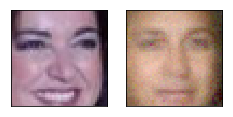

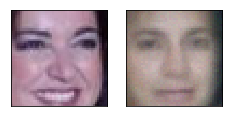

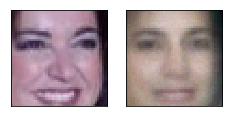

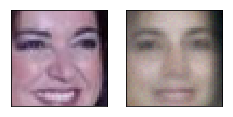

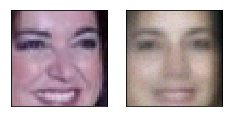

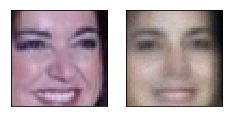

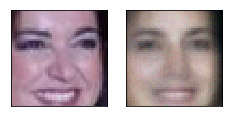

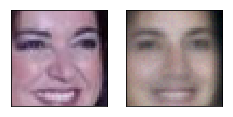

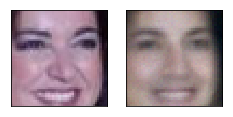

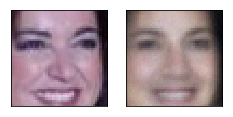

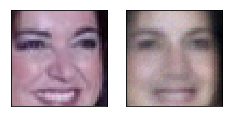

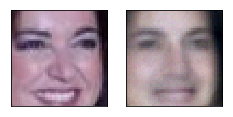

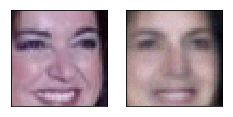

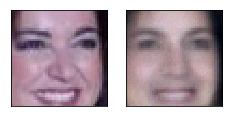

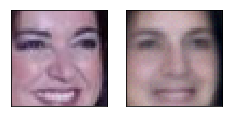

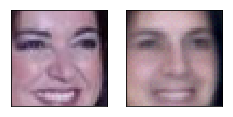

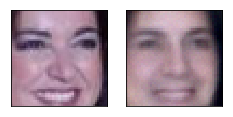

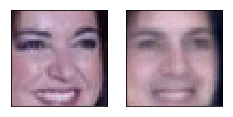

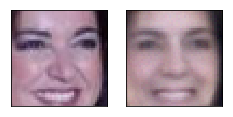

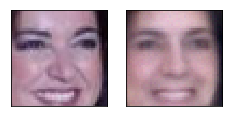

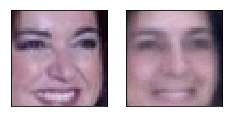

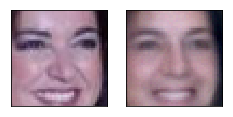

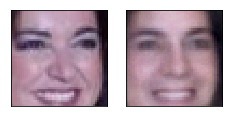

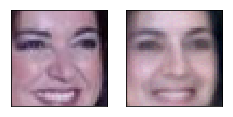

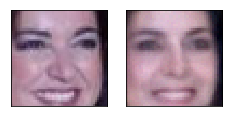

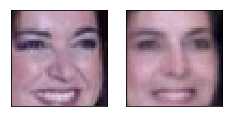

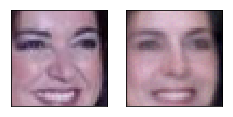

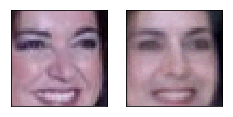

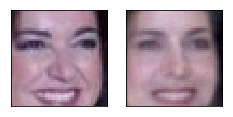

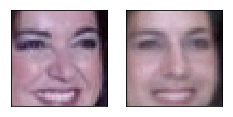

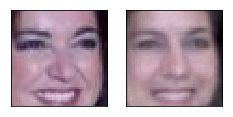

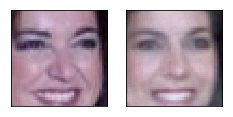

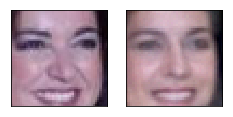

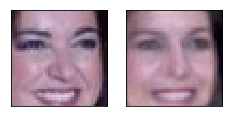

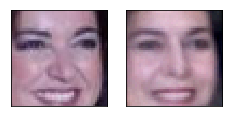

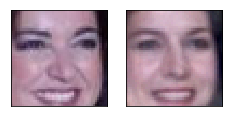

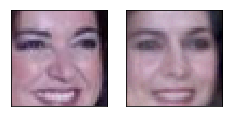

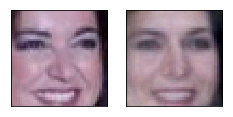

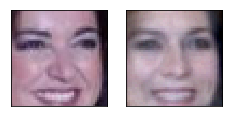

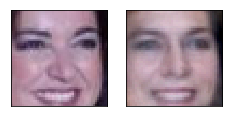

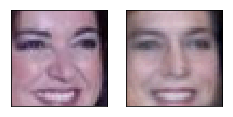

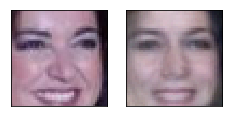

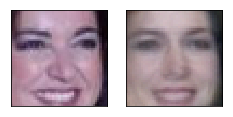

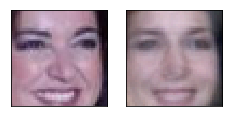

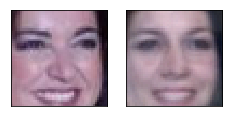

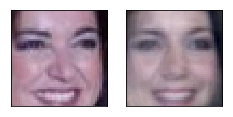

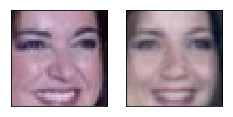

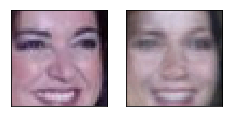

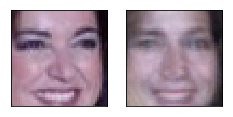

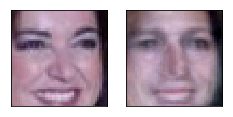

In [17]:
history = train(X_train, X_val, model_auto, epochs=50, batch_size=64)

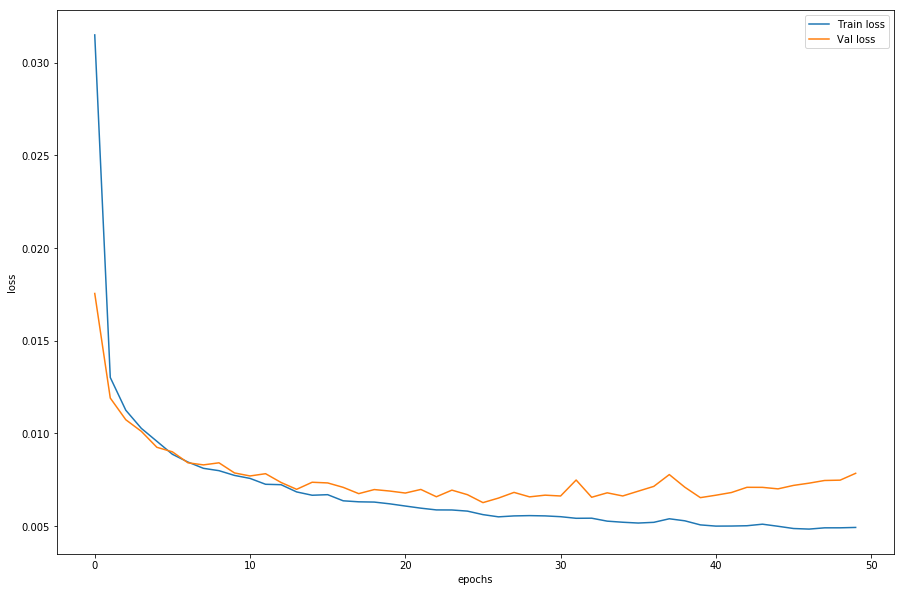

In [18]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

# Sampling

Let's generate some samples from random vectors

(25, 100)


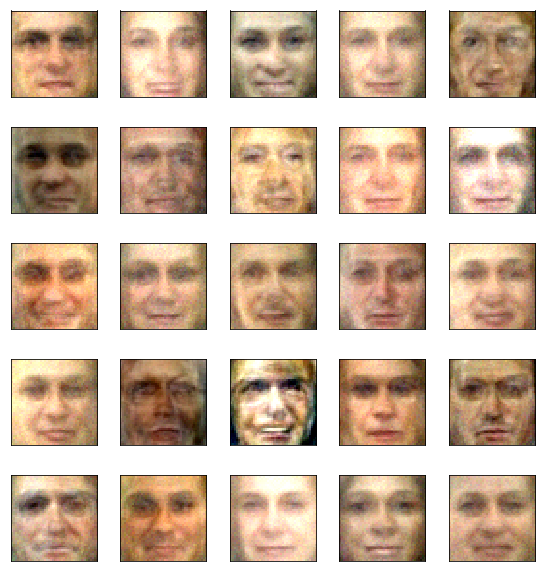

In [19]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_auto.eval()
    output = model_auto.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

# Adding smile and glasses

Let's find some attributes like smiles or glasses on the photo and try to add it to the photos which don't have it. We will use the second dataset for it. It contains a bunch of such attributes. 

In [20]:
attrs.head()

Male     Asian     White     Black     Baby     Child      Youth  \
0   1.56835  -1.88904    1.7372 -0.929729  -1.4718  -0.19558  -0.835609   
1  0.169851 -0.982408  0.422709  -1.28218 -1.36006 -0.867002  -0.452293   
2  0.997749  -1.36419 -0.157377 -0.756447 -1.89183 -0.871526  -0.862893   
3   1.12272   -1.9978   1.91614  -2.51421 -2.58007  -1.40424  0.0575511   
4   1.07821   -2.0081   1.67621  -2.27806 -2.65185  -1.34841   0.649089   

   Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0    -0.351468  -1.01253  -0.719593  ...  0.361738           1.16612   
1    -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.0314447  -1.34152 -0.0900375  ...   1.54974           1.88475   
3  0.000195882  -1.27351   -1.43146  ...  0.567822         -0.176089   
4    0.0176564  -1.88911   -1.85721  ...  -1.46147         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0                -1.16492         -1.13999     -2.37175        -1.29993   
1                 0.87416        -0.945431    -0.268649     -0.00624408   
2               -0.999765         -1.35986     -1.91211        -1.09563   
3                 1.10812         -1.60094     -3.26461        0.813418   
4                0.119113         -1.12818     -3.16105       0.0826804   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682          -1.1449        0.694007        -0.826609  
1 -0.0304057        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]

In [21]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [22]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

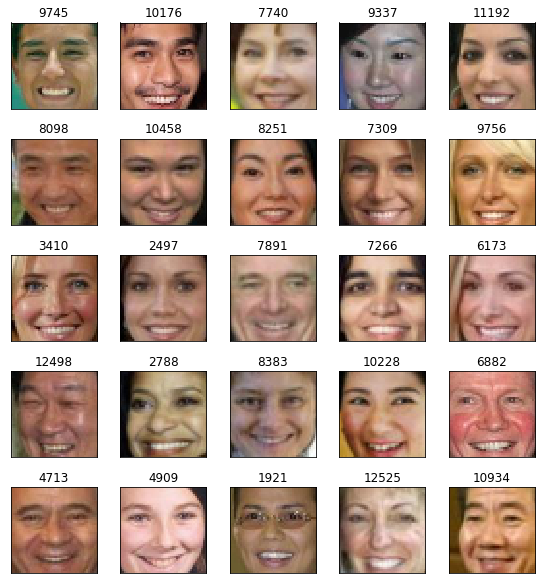

In [23]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

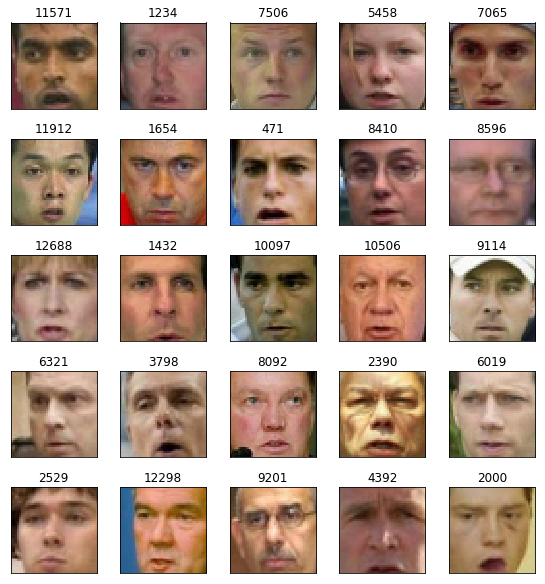

In [24]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

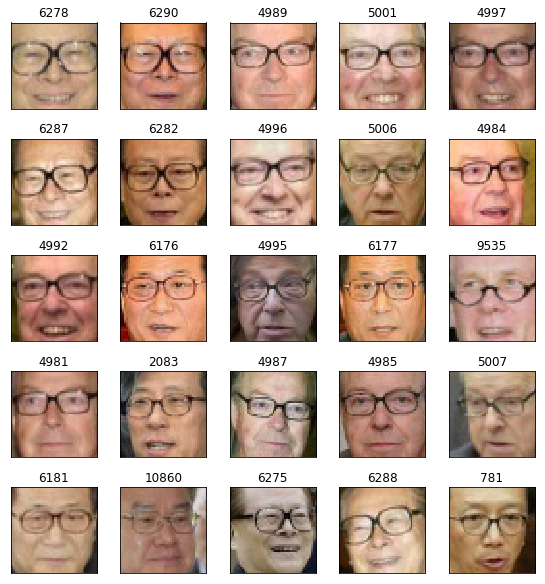

In [25]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=eyeglasses_ids)

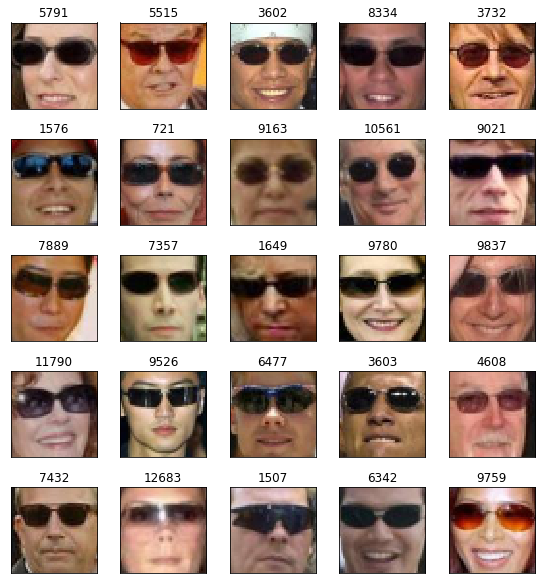

In [26]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=sunglasses_ids)

Calculating latent space vector for the selected images.

In [27]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_auto.eval()
        output = model_auto.encode(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_auto.eval()
        output = model_auto.decode(inputs)        
        return output

In [28]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
    

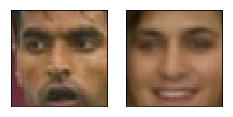

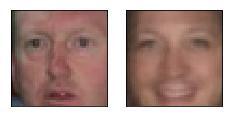

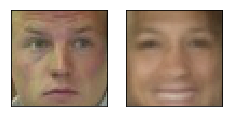

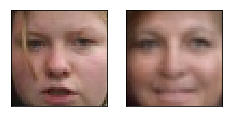

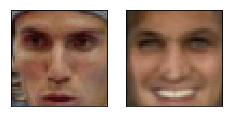

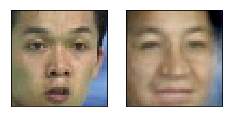

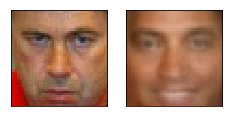

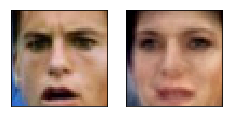

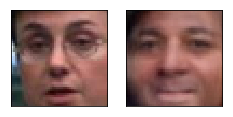

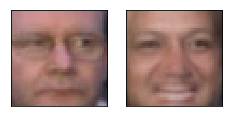

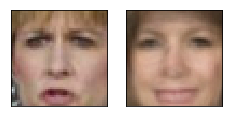

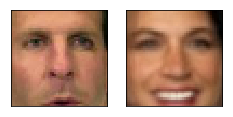

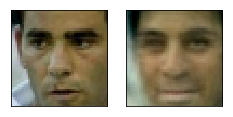

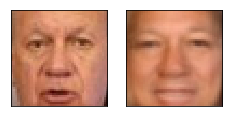

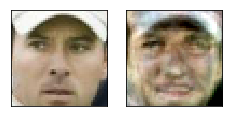

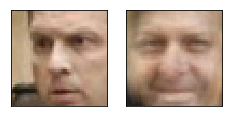

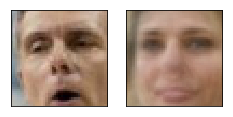

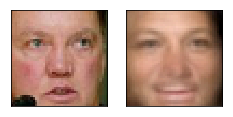

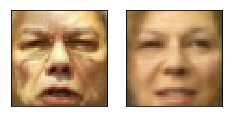

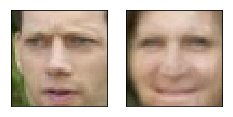

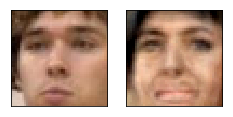

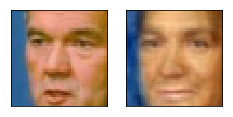

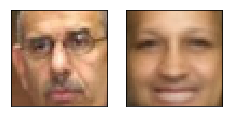

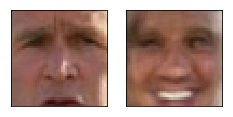

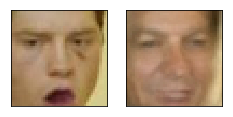

In [29]:
make_me_smile(no_smile_ids)

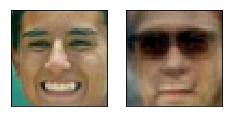

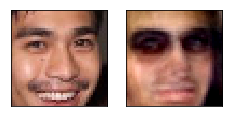

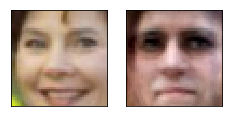

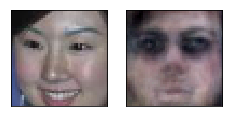

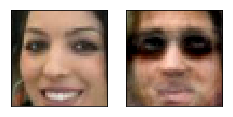

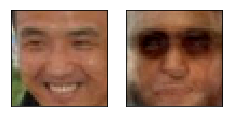

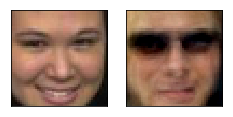

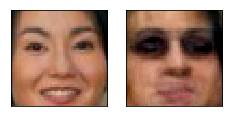

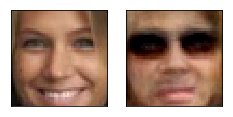

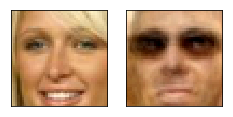

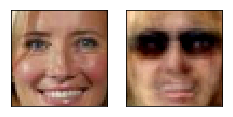

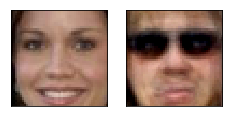

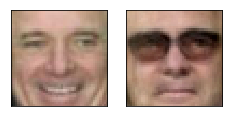

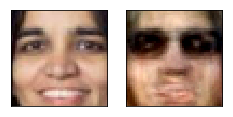

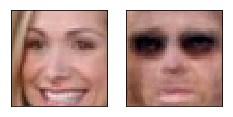

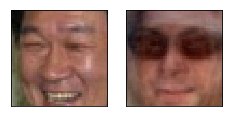

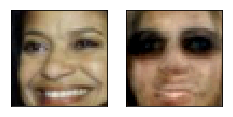

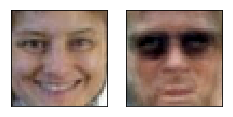

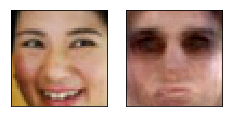

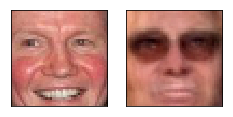

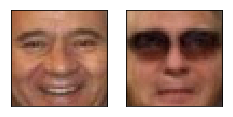

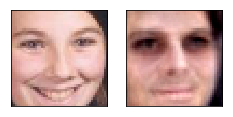

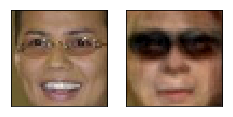

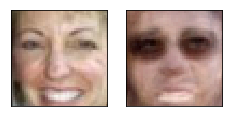

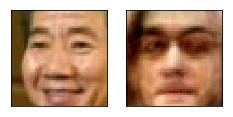

In [30]:
give_me_sunglasses(smile_ids)

While the concept is pretty straightforward the simple autoencoder have some disadvantages. Let's explore them and try to do better.

# Variational autoencoder

So far we have trained our encoder to reconstruct the very same image that we've transfered to latent space. That means that when we're trying to **generate** new image from the point decoder never met we're getting _the best image it can produce_, but the quelity is not good enough. 

> **In other words the encoded vectors may not be continuous in the latent space.**

In other hand Variational Autoencoders makes not only one encoded vector but **two**:
- vector of means, μ;
- vector of standard deviations, σ.

![https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png](https://miro.medium.com/max/657/1*CiVcrrPmpcB1YGMkTF7hzA.png)

> picture from https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf



In [31]:
dim_z = 256

In [32]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [33]:
model_vae = VAE().to(DEVICE)

In [34]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:21<17:51, 21.86s/it]

loss:  508120.28511984023

Epoch 001 train_loss: 508120.2851 val_loss: 496727.8195


epoch:   4%|▍         | 2/50 [00:43<17:19, 21.65s/it]

loss:  495394.6589205464

Epoch 002 train_loss: 495394.6589 val_loss: 488568.3817


epoch:   6%|▌         | 3/50 [01:04<16:55, 21.61s/it]

loss:  493193.11192071286

Epoch 003 train_loss: 493193.1119 val_loss: 486744.1023


epoch:   8%|▊         | 4/50 [01:26<16:39, 21.73s/it]

loss:  490973.348309397

Epoch 004 train_loss: 490973.3483 val_loss: 485825.5951


epoch:  10%|█         | 5/50 [01:47<16:13, 21.64s/it]

loss:  489486.4140833056

Epoch 005 train_loss: 489486.4141 val_loss: 484413.3128


epoch:  12%|█▏        | 6/50 [02:09<15:47, 21.53s/it]

loss:  488432.2336364015

Epoch 006 train_loss: 488432.2336 val_loss: 482633.5602


epoch:  14%|█▍        | 7/50 [02:31<15:36, 21.77s/it]

loss:  487355.9331546034

Epoch 007 train_loss: 487355.9332 val_loss: 481359.7556


epoch:  16%|█▌        | 8/50 [02:52<15:08, 21.64s/it]

loss:  488620.89016876306

Epoch 008 train_loss: 488620.8902 val_loss: 481359.0214


epoch:  18%|█▊        | 9/50 [03:14<14:49, 21.69s/it]

loss:  489040.4097483118

Epoch 009 train_loss: 489040.4097 val_loss: 482568.7704


epoch:  20%|██        | 10/50 [03:36<14:27, 21.69s/it]

loss:  486343.0698770687

Epoch 010 train_loss: 486343.0699 val_loss: 480531.1264


epoch:  22%|██▏       | 11/50 [03:57<14:01, 21.57s/it]

loss:  484703.51774717047

Epoch 011 train_loss: 484703.5177 val_loss: 479745.1415


epoch:  24%|██▍       | 12/50 [04:19<13:44, 21.69s/it]

loss:  484253.65864412923

Epoch 012 train_loss: 484253.6586 val_loss: 478759.1256


epoch:  26%|██▌       | 13/50 [04:41<13:19, 21.61s/it]

loss:  483511.21736048366

Epoch 013 train_loss: 483511.2174 val_loss: 479047.7071


epoch:  28%|██▊       | 14/50 [05:02<12:52, 21.46s/it]

loss:  483257.9701855859

Epoch 014 train_loss: 483257.9702 val_loss: 479451.0739


epoch:  30%|███       | 15/50 [05:24<12:37, 21.64s/it]

loss:  482575.1384612184

Epoch 015 train_loss: 482575.1385 val_loss: 479158.2058


epoch:  32%|███▏      | 16/50 [05:45<12:15, 21.63s/it]

loss:  482919.6732437108

Epoch 016 train_loss: 482919.6732 val_loss: 478231.4861


epoch:  34%|███▍      | 17/50 [06:07<11:53, 21.62s/it]

loss:  482579.6041022684

Epoch 017 train_loss: 482579.6041 val_loss: 477474.6150


epoch:  36%|███▌      | 18/50 [06:29<11:37, 21.80s/it]

loss:  482588.6435764219

Epoch 018 train_loss: 482588.6436 val_loss: 477599.6963


epoch:  38%|███▊      | 19/50 [06:51<11:14, 21.76s/it]

loss:  481563.1991912569

Epoch 019 train_loss: 481563.1992 val_loss: 477467.9310


epoch:  40%|████      | 20/50 [07:13<10:51, 21.73s/it]

loss:  481889.62368776154

Epoch 020 train_loss: 481889.6237 val_loss: 476363.3876


epoch:  42%|████▏     | 21/50 [07:34<10:31, 21.78s/it]

loss:  481303.72087217047

Epoch 021 train_loss: 481303.7209 val_loss: 477158.7561


epoch:  44%|████▍     | 22/50 [07:56<10:08, 21.74s/it]

loss:  480993.00101947406

Epoch 022 train_loss: 480993.0010 val_loss: 476844.4581


epoch:  46%|████▌     | 23/50 [08:18<09:50, 21.87s/it]

loss:  480887.45346532005

Epoch 023 train_loss: 480887.4535 val_loss: 476476.1125


epoch:  48%|████▊     | 24/50 [08:40<09:26, 21.79s/it]

loss:  480910.0324284882

Epoch 024 train_loss: 480910.0324 val_loss: 476250.0125


epoch:  50%|█████     | 25/50 [09:01<09:01, 21.66s/it]

loss:  481068.51392339973

Epoch 025 train_loss: 481068.5139 val_loss: 476035.9447


epoch:  52%|█████▏    | 26/50 [09:23<08:42, 21.79s/it]

loss:  480319.18749256944

Epoch 026 train_loss: 480319.1875 val_loss: 476269.7935


epoch:  54%|█████▍    | 27/50 [09:45<08:18, 21.68s/it]

loss:  480893.07449888246

Epoch 027 train_loss: 480893.0745 val_loss: 476418.0260


epoch:  56%|█████▌    | 28/50 [10:06<07:57, 21.70s/it]

loss:  479962.59329227696

Epoch 028 train_loss: 479962.5933 val_loss: 475322.2452


epoch:  58%|█████▊    | 29/50 [10:28<07:37, 21.79s/it]

loss:  479826.689943171

Epoch 029 train_loss: 479826.6899 val_loss: 477197.9640


epoch:  60%|██████    | 30/50 [10:50<07:15, 21.75s/it]

loss:  480367.01558636106

Epoch 030 train_loss: 480367.0156 val_loss: 475532.6247


epoch:  62%|██████▏   | 31/50 [11:12<06:53, 21.76s/it]

loss:  479709.1148037735

Epoch 031 train_loss: 479709.1148 val_loss: 476215.9175


epoch:  64%|██████▍   | 32/50 [11:34<06:34, 21.91s/it]

loss:  479585.45734556305

Epoch 032 train_loss: 479585.4573 val_loss: 475224.4016


epoch:  66%|██████▌   | 33/50 [11:56<06:10, 21.77s/it]

loss:  479617.21929391765

Epoch 033 train_loss: 479617.2193 val_loss: 474824.6955


epoch:  68%|██████▊   | 34/50 [12:17<05:48, 21.78s/it]

loss:  479530.975739193

Epoch 034 train_loss: 479530.9757 val_loss: 475059.9425


epoch:  70%|███████   | 35/50 [12:39<05:27, 21.82s/it]

loss:  479451.44632454345

Epoch 035 train_loss: 479451.4463 val_loss: 475263.4885


epoch:  72%|███████▏  | 36/50 [13:01<05:04, 21.75s/it]

loss:  480205.17712543986

Epoch 036 train_loss: 480205.1771 val_loss: 475494.3097


epoch:  74%|███████▍  | 37/50 [13:23<04:44, 21.89s/it]

loss:  479327.77814996673

Epoch 037 train_loss: 479327.7781 val_loss: 474908.6316


epoch:  76%|███████▌  | 38/50 [13:44<04:20, 21.67s/it]

loss:  478981.4025555212

Epoch 038 train_loss: 478981.4026 val_loss: 475097.1261


epoch:  78%|███████▊  | 39/50 [14:06<03:57, 21.62s/it]

loss:  479099.1679115346

Epoch 039 train_loss: 479099.1679 val_loss: 476941.6335


epoch:  80%|████████  | 40/50 [14:28<03:37, 21.76s/it]

loss:  479100.553133025

Epoch 040 train_loss: 479100.5531 val_loss: 474572.9176


epoch:  82%|████████▏ | 41/50 [14:50<03:15, 21.77s/it]

loss:  478683.7308053548

Epoch 041 train_loss: 478683.7308 val_loss: 477933.0029


epoch:  84%|████████▍ | 42/50 [15:11<02:53, 21.70s/it]

loss:  479732.1362810895

Epoch 042 train_loss: 479732.1363 val_loss: 476651.9381


epoch:  86%|████████▌ | 43/50 [15:33<02:32, 21.81s/it]

loss:  479266.1500633084

Epoch 043 train_loss: 479266.1501 val_loss: 474148.6927


epoch:  88%|████████▊ | 44/50 [15:55<02:09, 21.64s/it]

loss:  478515.31443937845

Epoch 044 train_loss: 478515.3144 val_loss: 474755.7134


epoch:  90%|█████████ | 45/50 [16:17<01:48, 21.80s/it]

loss:  478492.4102402154

Epoch 045 train_loss: 478492.4102 val_loss: 474065.4448


epoch:  92%|█████████▏| 46/50 [16:38<01:26, 21.71s/it]

loss:  478451.2598291564

Epoch 046 train_loss: 478451.2598 val_loss: 474108.1930


epoch:  94%|█████████▍| 47/50 [16:59<01:04, 21.55s/it]

loss:  478234.2211604765

Epoch 047 train_loss: 478234.2212 val_loss: 475450.6653


epoch:  96%|█████████▌| 48/50 [17:21<00:43, 21.70s/it]

loss:  478409.5918700661

Epoch 048 train_loss: 478409.5919 val_loss: 474482.0764


epoch:  98%|█████████▊| 49/50 [17:43<00:21, 21.55s/it]

loss:  478798.17715516215

Epoch 049 train_loss: 478798.1772 val_loss: 474381.2624


epoch: 100%|██████████| 50/50 [18:04<00:00, 21.70s/it]

loss:  478117.46852559684

Epoch 050 train_loss: 478117.4685 val_loss: 474120.2905


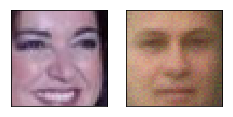

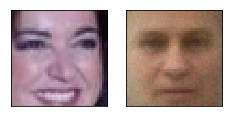

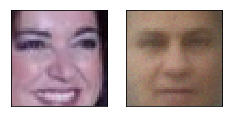

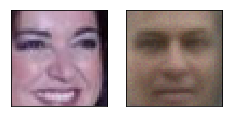

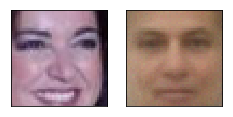

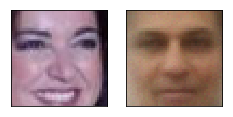

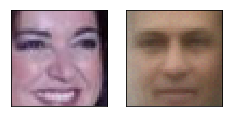

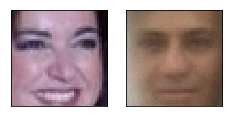

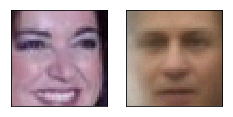

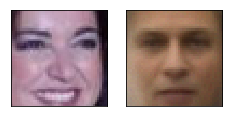

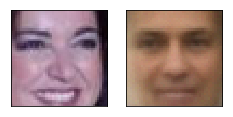

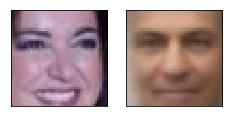

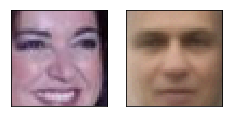

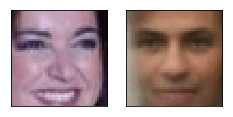

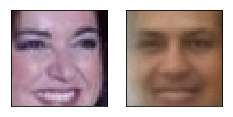

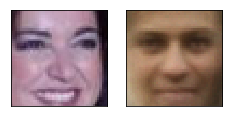

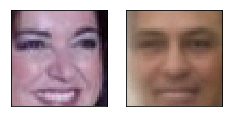

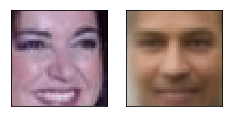

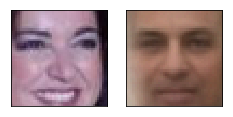

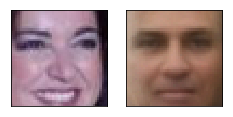

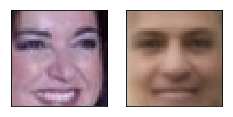

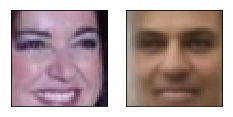

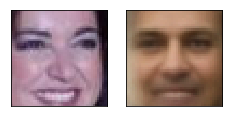

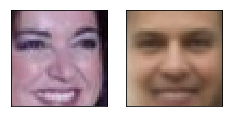

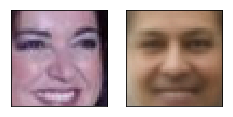

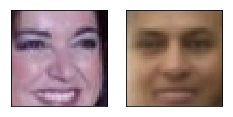

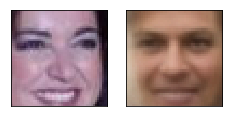

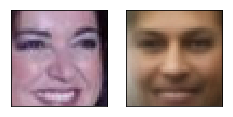

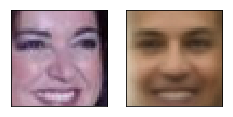

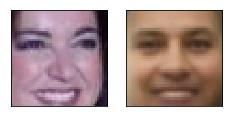

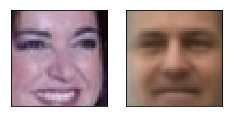

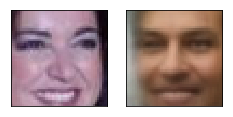

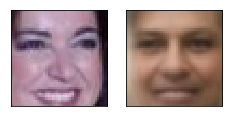

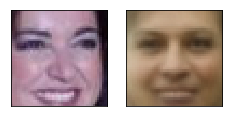

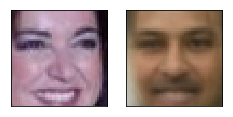

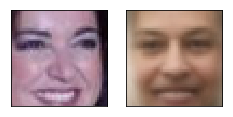

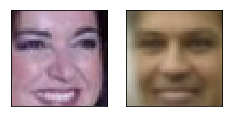

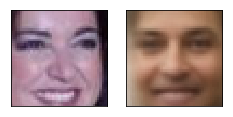

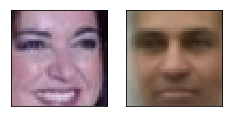

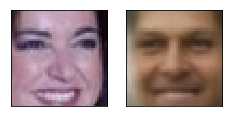

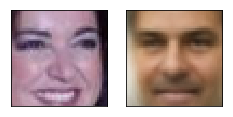

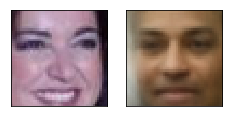

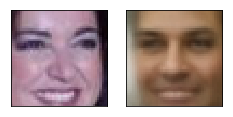

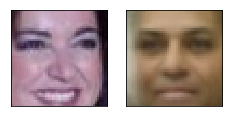

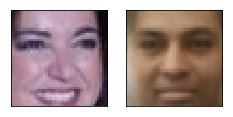

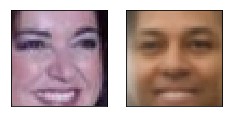

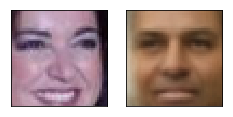

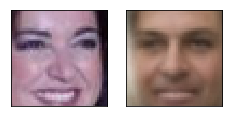

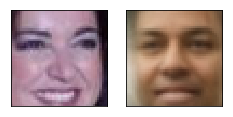

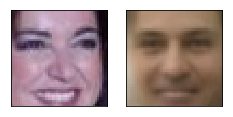

In [35]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.001)

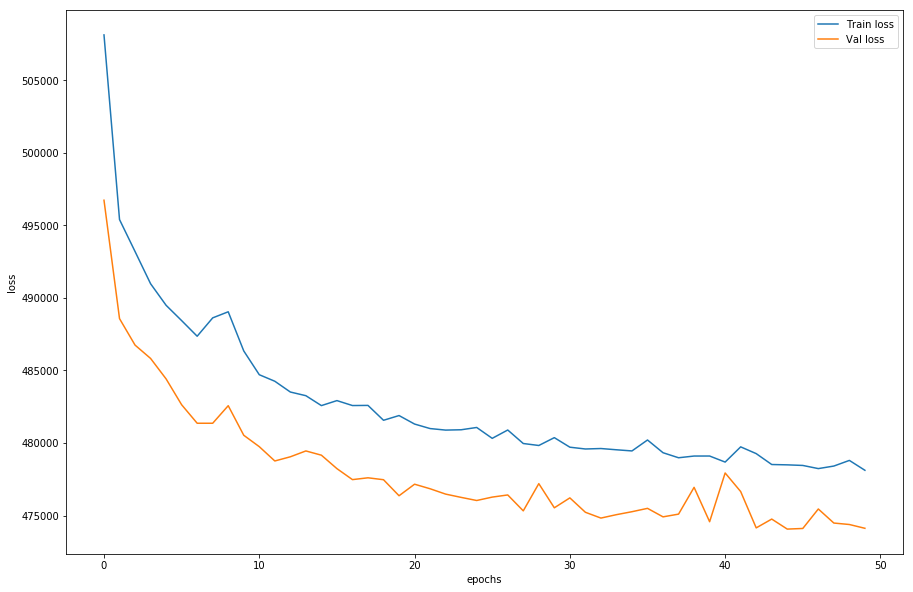

In [36]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

# Conclusion

Variational autoencoders are cool. Although models in this particular notebook are simple they let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces and high-resolution digital artwork.
These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma et al. and Rezende et al.